## Price movement from 2:00PM to 2:30PM

In [1]:
# Idea
# Khoang cach(bar) tu cay nen 2h den cay nen cao nhat va thap nhat trong ngay(2 cases: truoc va sau 2h)
# Percent price giua gia luc 2h va gia cao nhat, thap nhat trong ngay
# Su phu thuoc cua return vao 2 yeu to tren

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [4]:
data = dataset.copy()

In [5]:
### Ignore this year data => tranh over fitting
data = data[data.index < '2024-01-01 00:00:00']

In [6]:
def cal_first_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 915]
  if not tick.empty:
    return tick[0]


def cal_high_before(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1345]
  return tick.max()

def cal_high_after(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1345]
  tick = tick[100*tick.index.hour+tick.index.minute < 1430]
  return tick.max()


def cal_low_before(tick):
  tick = tick[100*tick.index.hour+tick.index.minute < 1355]
  return tick.min()


def cal_low_after(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 1355]
  tick = tick[100*tick.index.hour+tick.index.minute < 1430]
  return tick.min()


def cal_price(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1355]
  if not tick.empty:
    return tick[0]

def cal_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1425]
  if not tick.empty:
    return tick[0]
      
def cal_last(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1445]
  if not tick.empty:
    return tick[0]

In [7]:
data['first_close'] = data.Close
data['price'] = data.Close
data['_last'] = data.Close
data['prev_high'] = data.High
data['prev_low'] = data.Low
data['next_high'] = data.High
data['next_low'] = data.Low
price = data.resample("D").agg({
    'first_close': cal_first_close,
    'prev_high':cal_high_before,
    'prev_low': cal_low_before,
    'next_high':cal_high_after,
    'next_low': cal_low_after,
    'price': cal_price,
    'Close': cal_close,
    '_last': cal_last
    })
price = price.dropna()

In [8]:
price

,first_close,prev_high,prev_low,next_high,next_low,price,Close,_last
Date,,,,,,,,
2018-08-14,956.9,958.6,952.1,961.8,959.0,959.5,960.1,959.3
2018-08-15,960.7,962.3,954.7,959.9,949.9,959.2,951.2,946.6
2018-08-16,942.1,943.5,935.5,947.3,942.6,943.0,944.5,947.0
2018-08-17,953.2,954.6,946.4,949.9,945.0,946.5,947.0,947.0
2018-08-20,946.1,951.5,944.1,951.0,942.6,946.5,944.7,945.0
...,...,...,...,...,...,...,...,...
2023-12-25,1105.3,1117.7,1096.3,1119.2,1114.6,1116.6,1114.9,1115.0
2023-12-26,1116.4,1117.2,1113.4,1119.0,1114.7,1116.7,1117.2,1121.5
2023-12-27,1121.4,1124.8,1120.4,1126.2,1118.0,1125.8,1118.0,1116.9


In [9]:
len(price[(price.next_high - price.price > 0) & (price.price - price.next_low > 0)])

1265

In [10]:
len(price[(price.next_high - price.price > 3) & (price.price - price.next_low > 3)])

268

In [11]:
# mom_y = momentum_yesterday
price['mom_y'] = 100 * (price.price - price._last.shift(1)) / price._last.shift(1)
price['body_rate'] = (price.price - price.first_close) / (price.prev_high - price.prev_low)
price['return'] = 1000 * (price.Close - price.price) / price.price
price['next_high_rate'] = 1000 * (price.next_high - price.price) / price.price
price['next_low_rate'] = 1000 * (price.next_low - price.price) / price.price

### Estimated return - distribution

In [12]:
price['return'].describe()

count    1332.000000
mean       -0.182972
std         5.976855
min       -25.482943
25%        -2.813928
50%         0.154657
75%         2.775381
max        29.089314
Name: return, dtype: float64

In [13]:
price['return_group'] = pd.cut(price['return'], 30)
r1 = price.groupby(['return_group'])[['return']].count()
r11 = r1[['return']].rename(columns={'return': 'count'})
r11

,count
return_group,
"(-25.538, -23.664]",2
"(-23.664, -21.845]",2
"(-21.845, -20.026]",4
"(-20.026, -18.207]",5
"(-18.207, -16.388]",7
"(-16.388, -14.568]",13
"(-14.568, -12.749]",12
"(-12.749, -10.93]",16
"(-10.93, -9.111]",16


In [14]:
# Think about drop the outlier data
#price = price[(price['return'] > -20) & (price['return'] < 15)]

### Body rate - distribution

In [15]:
price['body_rate'].describe()

count    1332.000000
mean        0.010476
std         0.560707
min        -1.537037
25%        -0.462177
50%         0.014946
75%         0.471905
max         1.390244
Name: body_rate, dtype: float64

In [16]:
price['body_rate_group'] = pd.qcut(price.body_rate, 30)

### Momentum today-yesterday - distribution

In [17]:
price['mom_y'].describe()

count    1331.000000
mean        0.037107
std         1.298309
min       -10.381944
25%        -0.411539
50%         0.069444
75%         0.608522
max         9.806157
Name: mom_y, dtype: float64

In [18]:
price['mom_y_group'] = pd.qcut(price.mom_y, 20)

### Next high_rate & low_rate - distribution

In [19]:
price['next_high_rate'].describe()

count    1332.000000
mean        4.082710
std         3.970707
min         0.000000
25%         1.497029
50%         2.954282
75%         5.195012
max        31.272210
Name: next_high_rate, dtype: float64

In [20]:
price['next_low_rate'].describe()

count    1332.000000
mean       -3.919128
std         4.478023
min       -34.263792
25%        -5.340761
50%        -2.480488
75%        -0.913040
max         1.283331
Name: next_low_rate, dtype: float64

### Regplot

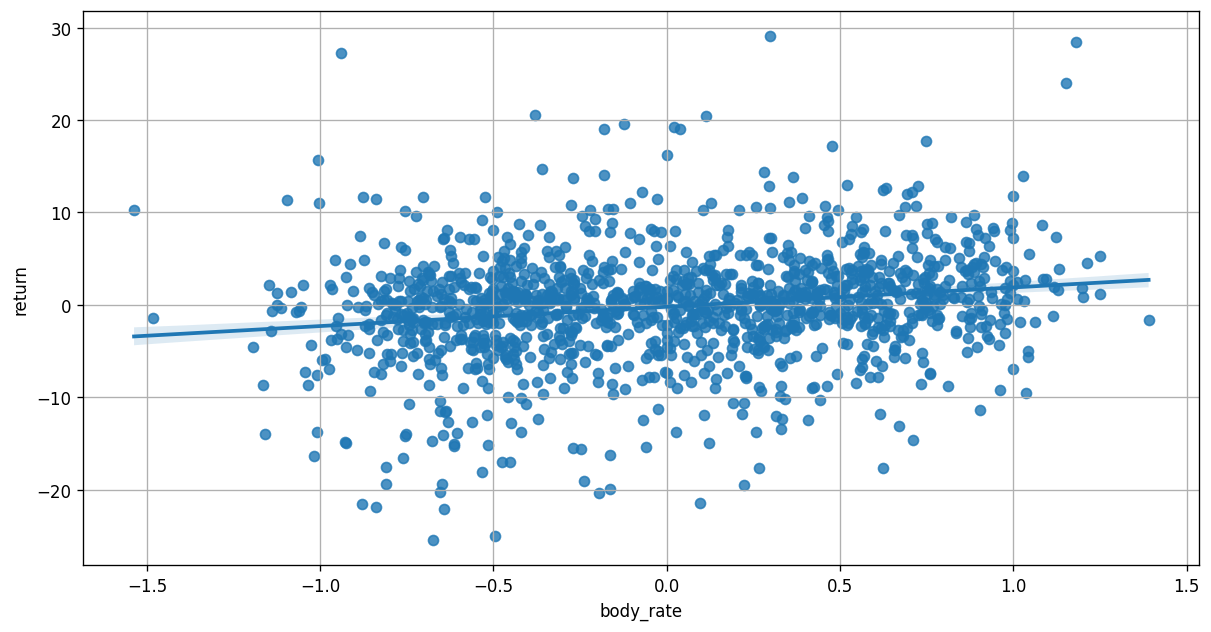

In [21]:
sns.regplot(x=price['body_rate'], y=price['return'])
plt.grid(True)

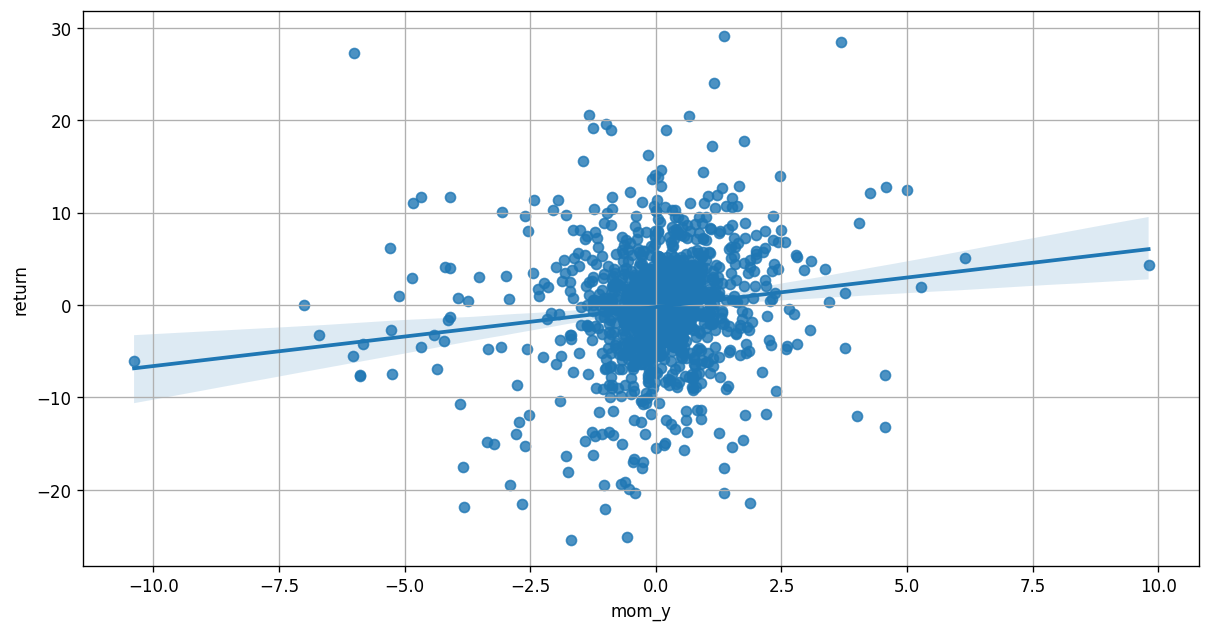

In [22]:
sns.regplot(x=price['mom_y'], y=price['return'])
plt.grid(True)

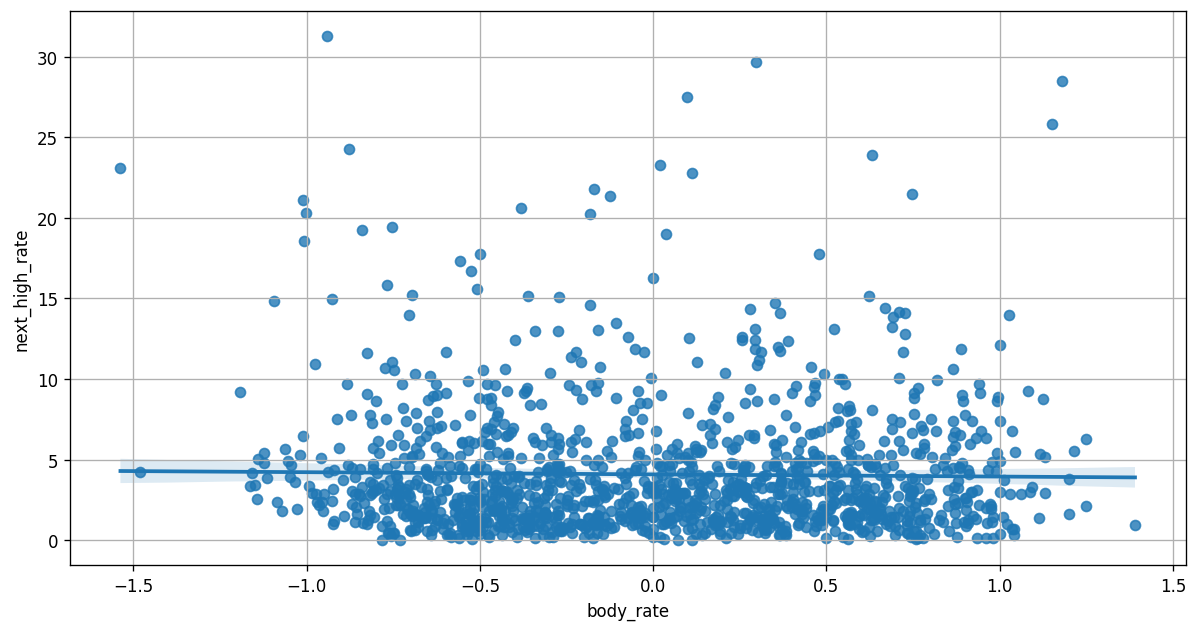

In [23]:
sns.regplot(x=price['body_rate'], y=price['next_high_rate'])
plt.grid(True)

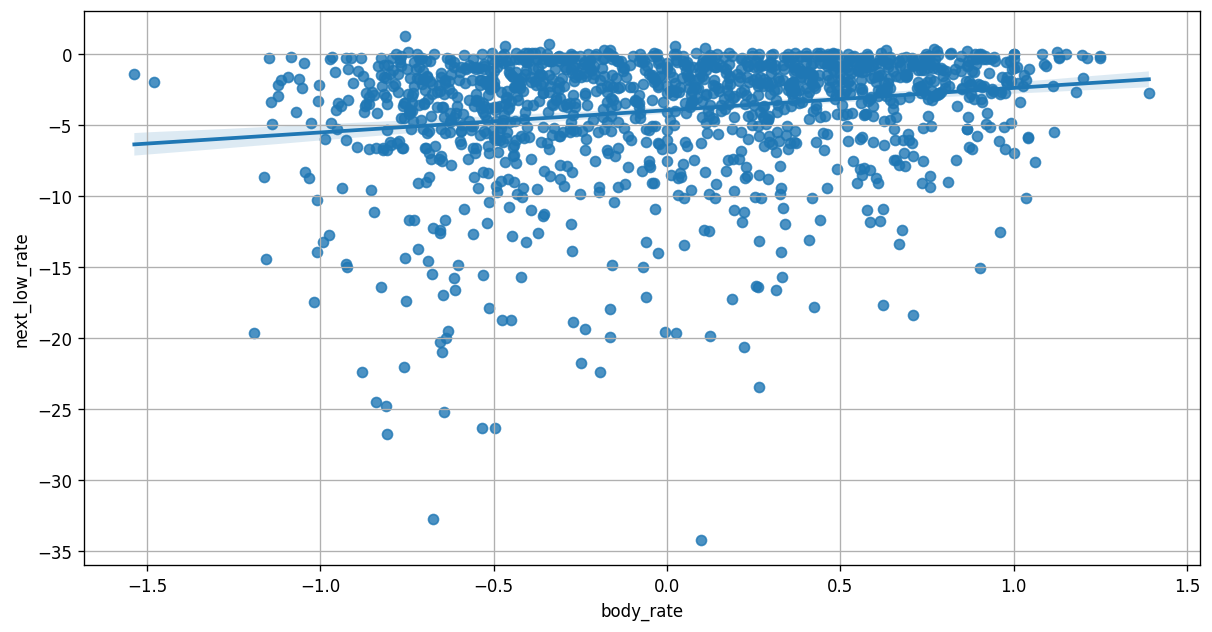

In [24]:
sns.regplot(x=price['body_rate'], y=price['next_low_rate'])
plt.grid(True)

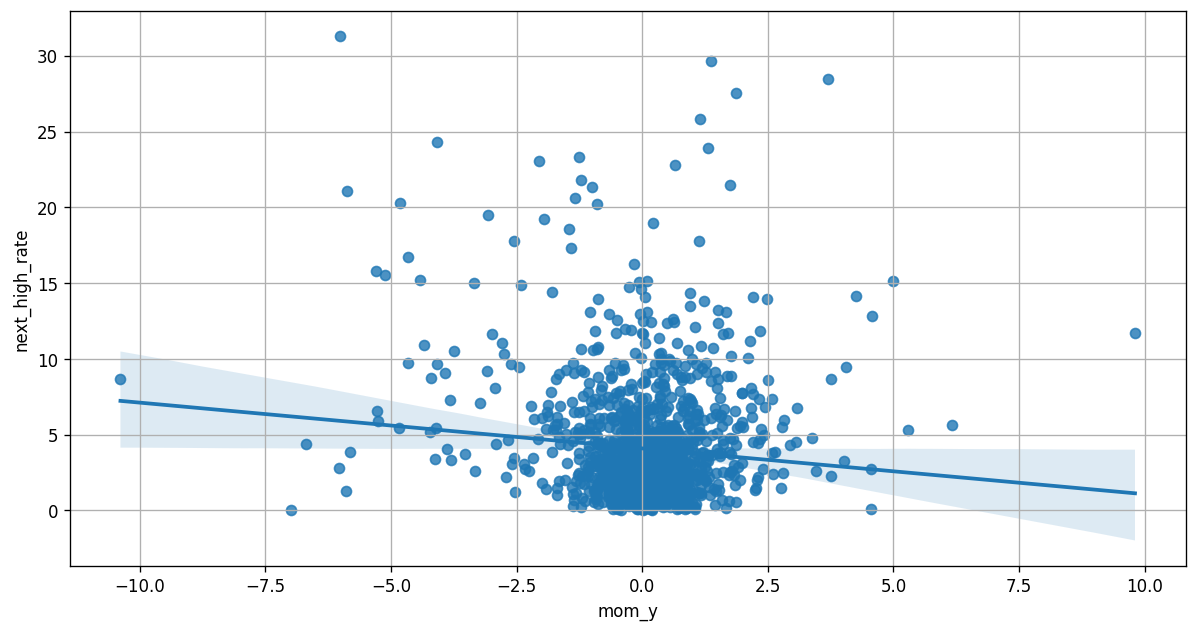

In [25]:
sns.regplot(x=price['mom_y'], y=price['next_high_rate'])
plt.grid(True)

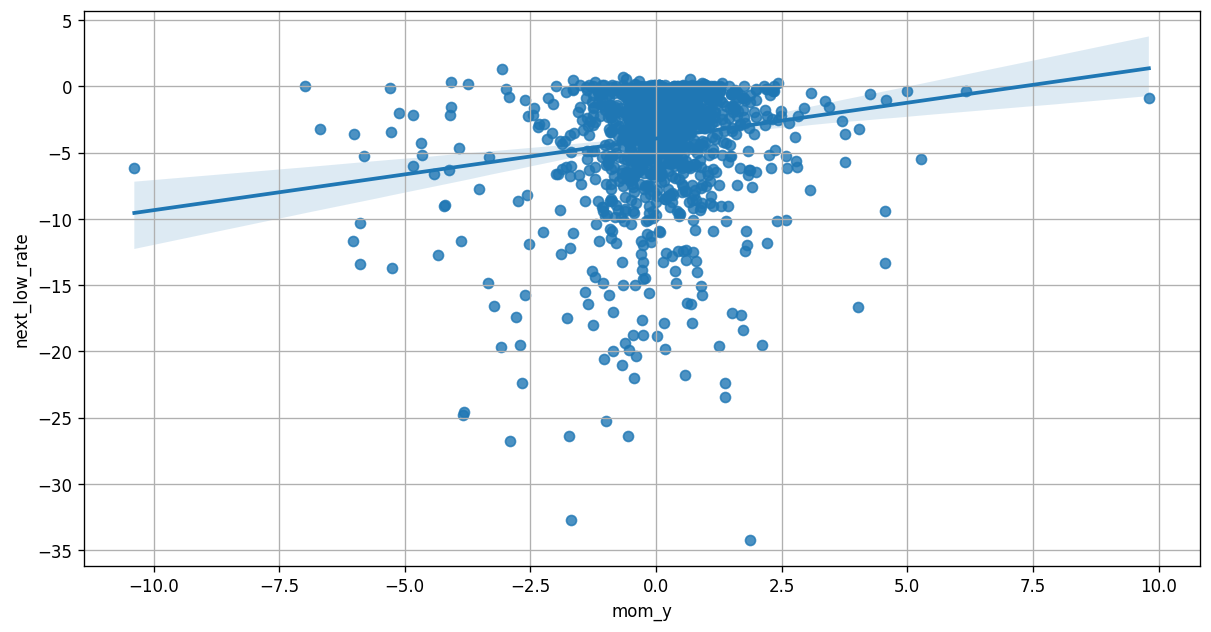

In [26]:
sns.regplot(x=price['mom_y'], y=price['next_low_rate'])
plt.grid(True)

### Heatmap

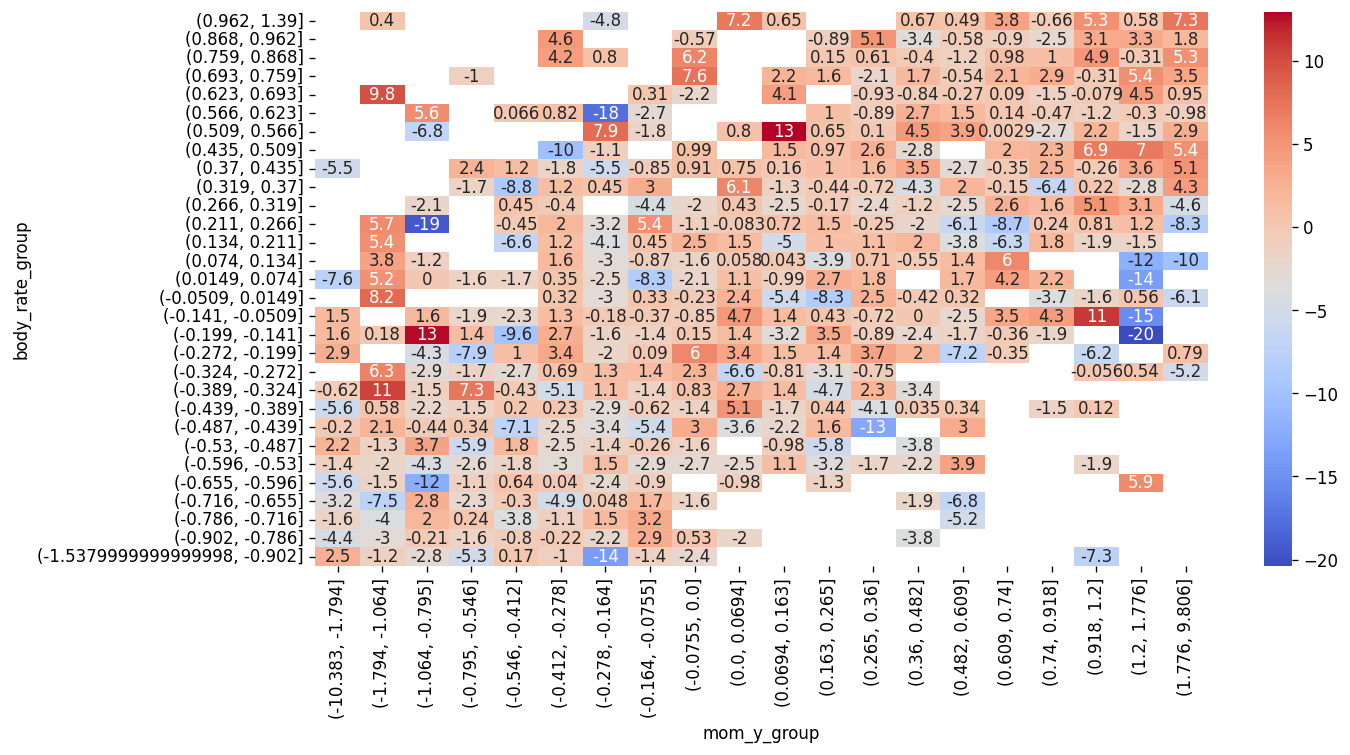

In [27]:
grpd = price.groupby(['body_rate_group', 'mom_y_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='body_rate_group', columns='mom_y_group', values='return').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

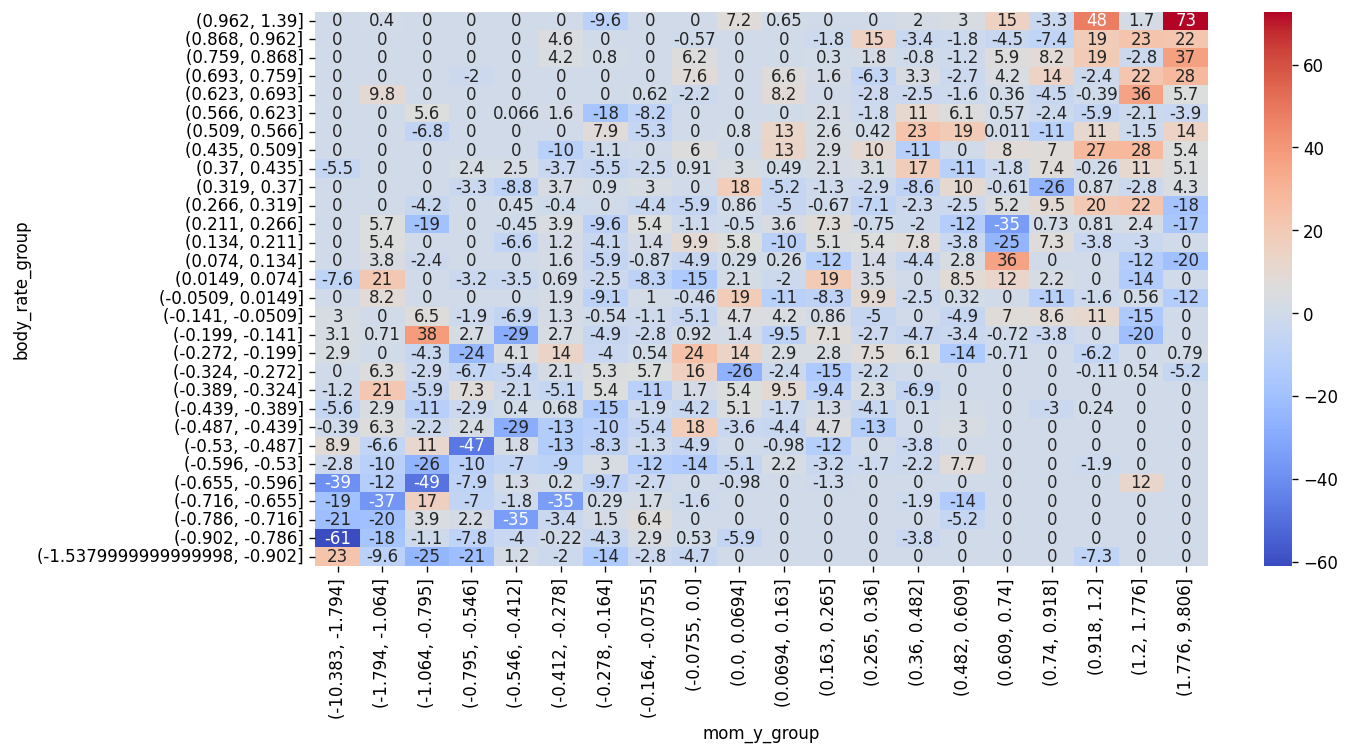

In [28]:
irs_sum = grpd.sum().reset_index()
sns.heatmap(
    irs_sum.pivot(index='body_rate_group', columns='mom_y_group', values='return').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);